In [1]:
%matplotlib inline
import warnings
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('float_format', '{:,.2f}'.format)
np.random.seed(42)

news_path = Path('results', 'financial_news')
data_path = news_path
analogy_path = Path('data', 'analogies-en.txt')

def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

In [2]:
gensim_path = news_path / 'gensim'
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

NGRAMS = 3           # Longest ngram in text
MIN_FREQ = 100
WINDOW_SIZE = 5
EMBEDDING_SIZE = 300
NEGATIVE_SAMPLES = 20
EPOCHS = 1
FILE_NAME = f'articles_{NGRAMS}_grams.txt'

# Sentence Generator
sentence_path = data_path / FILE_NAME
sentences = LineSentence(str(sentence_path))

In [3]:
# Train word2vec Model
start = time()
model = Word2Vec(sentences, sg=1, # set to 1 for skipgram; CBOW otherwise
                 vector_size=EMBEDDING_SIZE, window=WINDOW_SIZE, min_count=MIN_FREQ, negative=NEGATIVE_SAMPLES,
                 workers=8, epochs=EPOCHS, alpha=0.05)

# persist model
model.save(str(gensim_path / 'word2vec.model'))

# persist word vectors
model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration:', format_time(time() - start))

Duration: 00:03:33


In [4]:
import os
print(os.getcwd())

D:\99. Dev\Python\pythonProject\Final_Project\Quant_MDLing\MDLing


In [55]:
# Evaluate results
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'Total accuracy':'Total accuracy'}

def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='Total accuracy', ['correct', 'incorrect', 'average']].squeeze().tolist()

# gensim computes accuracy based on source text files
score, detailed_accuracy = model.wv.evaluate_word_analogies(analogy_path.as_posix(), case_insensitive=True)

# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      348         72     0.83
1                 capital-world      853        337     0.72
10  gram6-nationality-adjective      741        315     0.70
14               Total accuracy     3523       5607     0.39
11             gram7-past-tense      380        810     0.32
7             gram3-comparative      289        641     0.31
4                        family       41         91     0.31
2                 city-in-state      454       1190     0.28
8             gram4-superlative       71        235     0.23
12                 gram8-plural       66        240     0.22
3                      currency       36        142     0.20
9      gram5-present-participle      111        489     0.18
13           gram9-plural-verbs       86        420     0.17
5     gram1-adjective-to-adverb       40        422     0.09
6                gram2-opposite        7        203     0.03
Base Accuracy: Correct 3

In [42]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,smith,0.38
1,james,0.36
2,johnson,0.36
3,director,0.36
4,toronto_ontario,0.36
5,snyder,0.35
6,anderson,0.35
7,cindy,0.34
8,administrator,0.34
9,angela,0.34


In [43]:
counter = Counter(sentence_path.read_text(encoding='UTF8').split())

most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
credit,loan,revolving_credit_facility,revolving_credit,revolving,unsecured_revolving,borrowings,loans,debt,revolving_line,lending
conventions,enshrined,principles,practice,norms,forums,might_will_taken,standards,analytical,society,framework
teradata,ncr,vonage,tableau,sunpower,spx,godaddy,denny,symantec,aramark,marriott_vacations
places,people,areas,fortune_magazine,fortune,neighbors,there,cities,they,centres,neighbours
ftse,index,blue_chip,stocks,germany_dax,gainers,pct,blue_chip_ftse,msci,indexes,wall_street
wide_range,variety,wide_variety,wide_array,broad_array,array,specialized,broad,various,customized,multiple
cautioned_place_undue_reliance,place_undue_reliance,speak_date,unduly_rely,readers_cautioned_place_undue,speak_date_hereof,investors_place_undue,undue_reliance_placed,carefully_evaluating,speak_date_made,readers_place_undue
altice_usa,altice_nv,altice,optimum,cincinnati_bell,starz,sprint,t_mobile,essendant,idt,disney
warren,kevin,chris,joe,tom,brian,brad,steve,bob,ken,david
sophisticated,capabilities,automated,tools,cutting_edge,complex,specialized,customized,expertise,specializes,scalable


In [44]:
# Continue Training
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 10):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    score, detailed_accuracy = model.wv.evaluate_word_analogies(analogy_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save(str(gensim_path / f'word2vec_{i:02}.model'))
        model.wv.save(str(gensim_path / f'word_vectors_{i:02}.bin'))
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'])
     .to_csv(gensim_path / 'accuracies.csv', index=False))
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

01 | Duration: 00:02:58 | Accuracy: 39.65% 
02 | Duration: 00:03:00 | Accuracy: 39.88% 
03 | Duration: 00:03:01 | Accuracy: 39.35% 
04 | Duration: 00:03:06 | Accuracy: 38.55% 
05 | Duration: 00:03:02 | Accuracy: 38.09% 
06 | Duration: 00:02:56 | Accuracy: 38.70% 
07 | Duration: 00:02:57 | Accuracy: 38.57% 
08 | Duration: 00:03:04 | Accuracy: 38.84% 
09 | Duration: 00:03:01 | Accuracy: 38.59% 


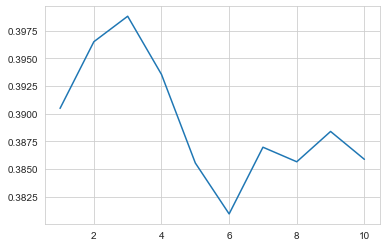

In [45]:
# Evaluate Best Model
pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'], index=list(range(1, len(accuracies) + 1))).average.plot();

In [46]:
best_model = Word2Vec.load((gensim_path / 'word2vec_06.model').as_posix())

# gensim computes accuracy based on source text files
score, detailed_accuracy = best_model.wv.evaluate_word_analogies(analogy_path.as_posix(), case_insensitive=True)

# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      344         76     0.82
10  gram6-nationality-adjective      796        260     0.75
1                 capital-world      848        342     0.71
14               Total accuracy     3596       5534     0.39
11             gram7-past-tense      398        792     0.33
2                 city-in-state      477       1167     0.29
7             gram3-comparative      269        661     0.29
4                        family       36         96     0.27
12                 gram8-plural       75        231     0.25
8             gram4-superlative       64        242     0.21
9      gram5-present-participle      122        478     0.20
13           gram9-plural-verbs       81        425     0.16
3                      currency       28        150     0.16
5     gram1-adjective-to-adverb       45        417     0.10
6                gram2-opposite       13        197     0.06
Base Accuracy: Correct 3

In [56]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total accuracy']
results = results.drop('Total accuracy')

most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,smith,0.39
1,william,0.34
2,anderson,0.34
3,james,0.34
4,cindy,0.34
5,howard,0.34
6,prince,0.34
7,baker,0.33
8,director,0.33
9,jackson,0.33


In [57]:
results

,Correct,Incorrect,Average
Category,,,
Capitals,348,72,0.83
Capitals RoW,853,337,0.72
City-State,454,1190,0.28
Currency,36,142,0.20
Famliy,41,91,0.31
Adj-Adverb,40,422,0.09
Opposite,7,203,0.03
Comparative,289,641,0.31
Superlative,71,235,0.23


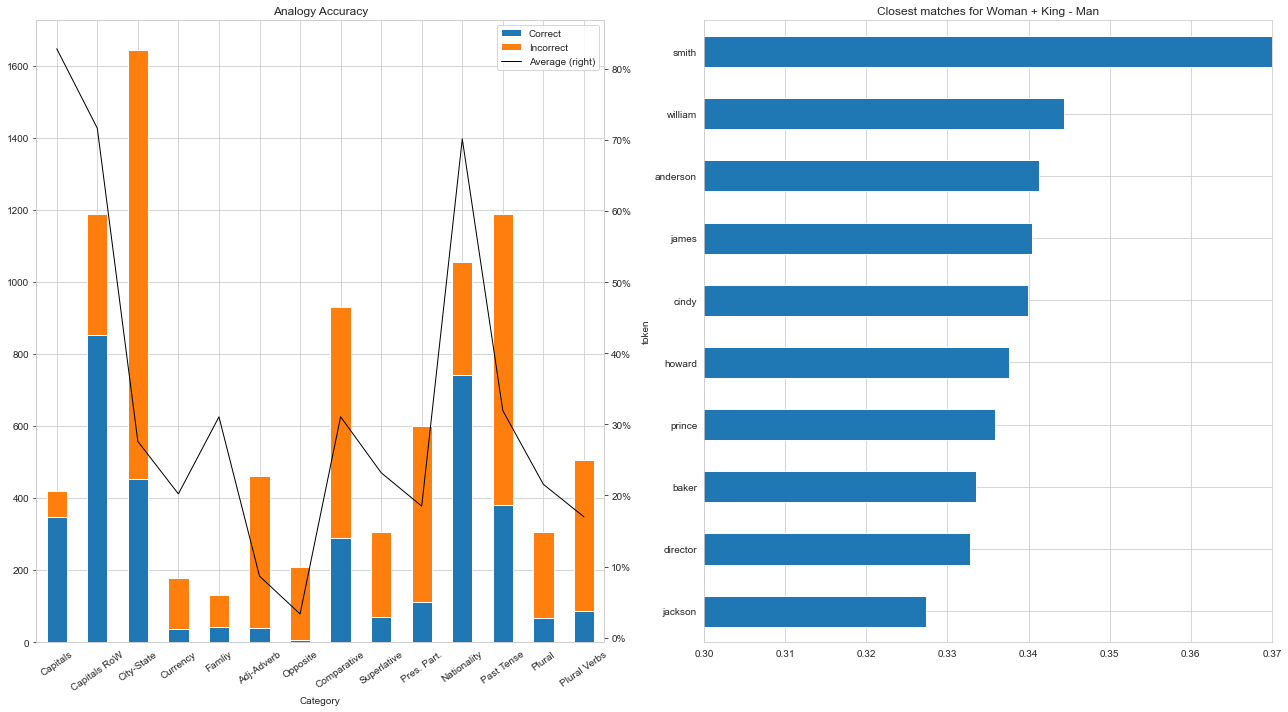

In [66]:
fig, axes = plt.subplots(figsize=(18, 10), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity']).set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout();

In [61]:
counter = Counter(sentence_path.read_text(encoding='UTF8').split())

most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in best_model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
prime_minister_malcolm_turnbull,turnbull,min_read_sydney,sydney,german_chancellor_angela_merkel,australian,asean,prime_minister_justin_trudeau,prime_minister_shinzo_abe,australia,merkel
user,users,customer,mobile,apps,client,functionality,device,devices,subscriber,monetization
lake,creek,county,valley,situated,located,ridge,acre,manitoba,river,bay
mistake,regret,wrong,thing,maybe,tweet,let,was,it,getting,absolutely
granting,granted,grants,exemptions,grant,allow,restrict,exemption,extend,permit,agreements
novichok,nerve_agent,military_grade_nerve,poison,poisoning,substance,skripals,opcw,skripal,chemical_weapons,soviet_union
repeatedly,saying,called,defended,criticized,accusations,concerns,has,critics,accused,refused
solid_tumors,cancers,cancer,tumors,therapy,solid_tumor,small_cell_lung,metastatic,nsclc,metastatic_breast_cancer,therapies
hermes,sainsbury,kering,elliott,murray,janus_henderson,gucci,vauxhall,santander,opel,irr
served,serving,serves,worked,roles,joins,vice,began_career,serve,joined,promoted


In [68]:
most_common.sample(10)

,token,count,p
8246,sue,393,0.00
13866,concho,180,0.00
12832,ig,202,0.00
8618,notices,364,0.00
290,paid,22794,0.00
15234,bright_spot,156,0.00
14676,leaves_european_union,165,0.00
4653,advocacy,974,0.00
8268,sadr,392,0.00
10945,celebrity,255,0.00


In [64]:
similars.T.iloc[:5, :5].to_csv(f'{gensim_path}/most_similar.csv')